In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

rng = np.random.default_rng(seed=100)

# Offsets and Exposures in GLM for Poisson regression

**TLDR:** We should use the keyword `exposure=sequencing_depth` in `statsmodels.GLM` to account for variation in total sequencing depth between timepoints.

In our Poisson regression model, we would like to be able to account for the fact that the number of reads supporting a given sequence should increase proportionally with the sequencing depth.
That is, if we have twice as many reads on day two than on day one, we expect to see twice as many reads (on average) supporting each sequence.

The `statsmodels.GLM` object provides two different ways to account for variations in the mean of the exogenous variable due to known factors: `offset` and `exposure`.
However, the documentation isn't 100% clear about how these work.
In the following, I'll play around with both to figure out what exactly they mean and how to use them.

In [2]:
?sm.GLM

Init signature:
sm.GLM(
    endog,
    exog,
    family=None,
    offset=None,
    exposure=None,
    freq_weights=None,
    var_weights=None,
    missing='none',
    **kwargs,
)
Docstring:     
Generalized Linear Models

GLM inherits from statsmodels.base.model.LikelihoodModel

Parameters
----------
endog : array_like
    1d array of endogenous response variable.  This array can be 1d or 2d.
    Binomial family models accept a 2d array with two columns. If
    supplied, each observation is expected to be [success, failure].
exog : array_like
    A nobs x k array where `nobs` is the number of observations and `k`
    is the number of regressors. An intercept is not included by default
    and should be added by the user (models specified using a formula
    include an intercept by default). See `statsmodels.tools.add_constant`.
family : family class instance
    The default is Gaussian.  To specify the binomial distribution
    family = sm.family.Binomial()
    Each family can take a l

We'll consider a simple example: $k \sim \text{Poisson}(e^j)$.
With no offsets or exposures, we expect $\hat{\beta_0} \approx 0$ and $\hat{\beta_1} \approx 1$.

In [3]:
def poisson_regression(k, **kwargs):
    fit = sm.GLM(
        k,
        sm.add_constant(np.arange(len(k))),
        family=sm.families.Poisson(),
        **kwargs,
    ).fit()
    print(f"beta_0 = {fit.params[0]:.3f}\nbeta_1 = {fit.params[1]:.3f}")
    return fit

beta_0 = 0.002
beta_1 = 1.000


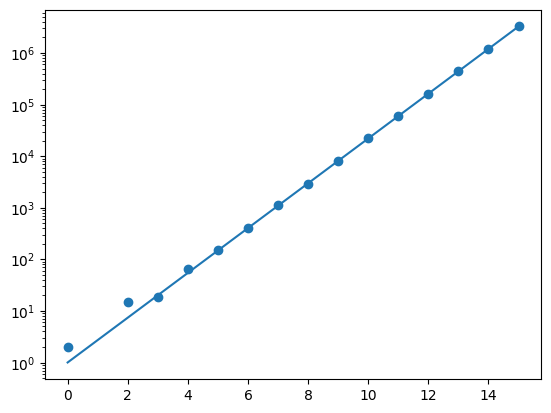

In [4]:
j = np.arange(16)
k = rng.poisson(np.exp(j))
fit = poisson_regression(k)
plt.scatter(j, k)
plt.semilogy(j, fit.fittedvalues)

Now let's try a constant offset of 1:

In [5]:
offset = np.ones_like(k)
fit = poisson_regression(k, offset=offset)

beta_0 = -0.998
beta_1 = 1.000


This shifts $\hat{\beta_0}$ down by 1 and leaves $\hat{\beta_1}$ alone, suggesting that `offset` works by shifting the linear predictor $\beta_0 + \beta_1 j$.
We can confirm that by trying a constant offset of 2:

In [6]:
offset = 2 * np.ones_like(k)
fit = poisson_regression(k, offset=offset)

beta_0 = -1.998
beta_1 = 1.000


In contrast, a constant exposure of 1 leaves everything unchanged, whereas a constant exposure of $e$ shifts $\hat{\beta_0}$ down by 1.

In [7]:
exposure = np.ones_like(k)
fit = poisson_regression(k, exposure=exposure)

beta_0 = 0.002
beta_1 = 1.000


In [8]:
exposure = np.exp(np.ones_like(k))
fit = poisson_regression(k, exposure=exposure)

beta_0 = -0.998
beta_1 = 1.000


This suggests that `exposure` works as multiplicative factor on the scale of the response variable.
We can test this by trying an exponentially growing exposure:

In [9]:
exposure = np.exp(j)
fit = poisson_regression(k, exposure=exposure)

beta_0 = 0.002
beta_1 = -0.000


In [10]:
exposure = np.exp(j / 2)
fit = poisson_regression(k, exposure=exposure)

beta_0 = 0.002
beta_1 = 0.500


An exposure growing at the same rate as the data cancels out the $\beta_1$, whereas an exposure growing half as fast cuts it in half.

This is the response we'd expect from variable sequencing depth.
So if we had a vector that represents the sequencing effort per sample, we should account for it by including keyword `exposure=sequencing_depth` in our `GLM` calls.

(Equivalently, we could use `offset=log(sequencing_depth)`, but that's mildly less transparent.)